<a href="https://colab.research.google.com/github/vivekvj18/ML-PROJECT-2/blob/main/ML_2(RBF_SVM_82_5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL 1 — Imports & settings
import time, gc, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

sns.set(style="whitegrid")
RANDOM_STATE = 42

def print_metrics(y_true, y_pred, name="Model"):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro')
    print(f"{name} — Accuracy : {acc:.4f}")
    print(f"{name} — Macro-F1 : {f1m:.4f}")
    print(classification_report(y_true, y_pred, digits=4))
    return acc, f1m

def plot_norm_cm(y_true, y_pred, title="Normalized Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm / cm.sum(axis=1, keepdims=True), cmap='viridis')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [ ]:
# CELL 2 — Load data and define columns
# If you already have `df` loaded in your session (from previous notebook), skip the read_csv
DATA_PATH = "covtype.csv"   # change if needed

try:
    df
    print("Using existing dataframe 'df' in memory with shape:", df.shape)
except NameError:
    df = pd.read_csv(DATA_PATH)
    print("Loaded dataframe from disk with shape:", df.shape)

# Continuous columns (UCI covtype)
continuous_cols = [
    'Elevation','Aspect','Slope',
    'Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

target_col = 'Cover_Type' if 'Cover_Type' in df.columns else df.columns[-1]
feature_cols = [c for c in df.columns if c != target_col]
binary_cols = [c for c in feature_cols if c not in continuous_cols]

print("Target:", target_col)
print("Total rows:", len(df))
print("Features:", len(feature_cols), "| continuous:", len(continuous_cols), "| binary:", len(binary_cols))


Loaded dataframe from disk with shape: (581012, 55)
Target: Cover_Type
Total rows: 581012
Features: 54 | continuous: 10 | binary: 44


In [ ]:
# FIXED CELL 3 — Robust stratified sampling using StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

SAMPLE_N = 80000  # change to 50000 or 40000 if you have memory issues

n_total = len(df)
if SAMPLE_N >= n_total:
    df_sample = df.copy().reset_index(drop=True)
    print("SAMPLE_N >= dataset size — using full dataset as sample:", n_total)
else:
    frac = SAMPLE_N / n_total
    sss = StratifiedShuffleSplit(n_splits=1, train_size=frac, random_state=RANDOM_STATE)
    # sss.split requires X and y; we'll pass df (X) and target column (y)
    train_idx, _ = next(sss.split(df, df[target_col]))
    df_sample = df.iloc[train_idx].reset_index(drop=True)
    print(f"Stratified sample drawn: requested {SAMPLE_N}, got {len(df_sample)} rows")

print("Sample target distribution (counts):")
print(df_sample[target_col].value_counts().sort_index())


Stratified sample drawn: requested 80000, got 80000 rows
Sample target distribution (counts):
Cover_Type
1    29169
2    39008
3     4923
4      378
5     1307
6     2391
7     2824
Name: count, dtype: int64


In [ ]:
# CELL 4 — Preprocessing & sample train/test split
# Clean sample (drop NaN/inf if present; normally not needed)
df_sample = df_sample.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

Xs = df_sample[feature_cols]
ys = df_sample[target_col].astype(int)

Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    Xs, ys, test_size=0.20, stratify=ys, random_state=RANDOM_STATE
)
print("Sample train/test shapes:", Xs_train.shape, Xs_test.shape)

# Preprocessor: scale continuous only
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_cols)
    ],
    remainder='passthrough'
)


Sample train/test shapes: (64000, 54) (16000, 54)


In [ ]:
# CELL 5 — GridSearchCV (RBF SVM) — small grid to save time
pipe_rbf = Pipeline([
    ('pre', preprocessor),
    ('clf', SVC(kernel='rbf', probability=False, random_state=RANDOM_STATE))
])

# small but effective grid
param_grid = {
    'clf__C': [1.0, 5.0],            # try 1 and 5
    'clf__gamma': ['scale', 0.01]    # default scale and one small gamma
    # optionally add 'clf__class_weight': [None, 'balanced'] but this slows fitting
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(pipe_rbf, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=2)

print("Starting GridSearchCV on sample (this may take several minutes)...")
t0 = time.time()
gs.fit(Xs_train, ys_train)
t1 = time.time()
print("GridSearch completed in {:.1f} seconds".format(t1 - t0))
print("Best params:", gs.best_params_)
print("Best CV f1_macro:", gs.best_score_)


Starting GridSearchCV on sample (this may take several minutes)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
GridSearch completed in 2210.1 seconds
Best params: {'clf__C': 5.0, 'clf__gamma': 'scale'}
Best CV f1_macro: 0.7120115175253002


RBF-SVC (sample) — Accuracy : 0.8259
RBF-SVC (sample) — Macro-F1 : 0.7308
              precision    recall  f1-score   support

           1     0.8308    0.7955    0.8128      5834
           2     0.8284    0.8799    0.8534      7802
           3     0.7974    0.8841    0.8386       984
           4     0.8868    0.6184    0.7287        76
           5     0.8085    0.2912    0.4282       261
           6     0.7089    0.5502    0.6196       478
           7     0.8726    0.8000    0.8347       565

    accuracy                         0.8259     16000
   macro avg     0.8191    0.6885    0.7308     16000
weighted avg     0.8253    0.8259    0.8225     16000



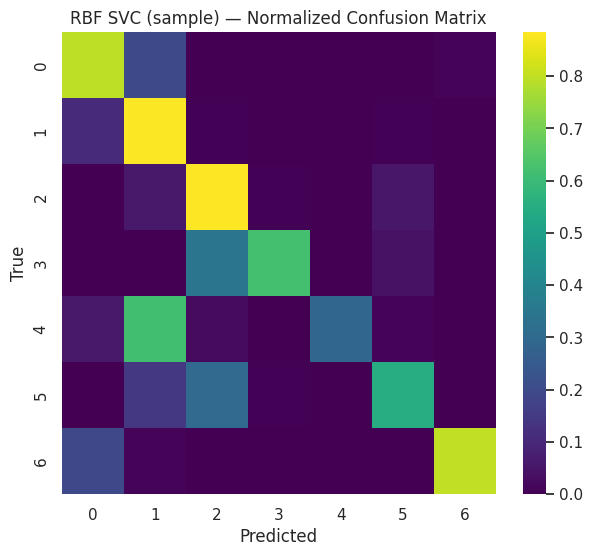

Saved best RBF SVC to 'rbf_svc_sample_best.pkl'

REPORT SNIPPET (paste to report):
RBF SVM (trained on stratified sample of 80000 rows) — best params: {'clf__C': 5.0, 'clf__gamma': 'scale'}.
Sample test accuracy = 0.8259, macro-F1 = 0.7308.
This non-linear model shows substantial improvement over linear models, confirming dataset non-linearity.


In [ ]:
# CELL 6 — Evaluate best RBF SVC on Xs_test
best_rbf = gs.best_estimator_

ys_pred = best_rbf.predict(Xs_test)
acc_rbf = accuracy_score(ys_test, ys_pred)
f1_rbf = f1_score(ys_test, ys_pred, average='macro')

print_metrics(ys_test, ys_pred, name="RBF-SVC (sample)")
plot_norm_cm(ys_test, ys_pred, title="RBF SVC (sample) — Normalized Confusion Matrix")

# Save best estimator
joblib.dump(best_rbf, "rbf_svc_sample_best.pkl")
print("Saved best RBF SVC to 'rbf_svc_sample_best.pkl'")

# Print short report snippet
print("\nREPORT SNIPPET (paste to report):")
print(f"RBF SVM (trained on stratified sample of {len(df_sample)} rows) — best params: {gs.best_params_}.")
print(f"Sample test accuracy = {acc_rbf:.4f}, macro-F1 = {f1_rbf:.4f}.")
print("This non-linear model shows substantial improvement over linear models, confirming dataset non-linearity.")


In [ ]:
# CELL 8 — Final tips and summary saving
results = {
    "model": "RBF_SVC_sample",
    "sample_rows": len(df_sample),
    "best_params": gs.best_params_,
    "cv_f1_macro": gs.best_score_,
    "test_accuracy": acc_rbf,
    "test_macro_f1": f1_rbf
}
pd.DataFrame([results]).to_csv("rbf_svm_sample_summary.csv", index=False)
print("Saved summary to rbf_svm_sample_summary.csv")
print("\nNext recommended steps:")
print("- If RBF-SVC sample performs best, include confusion matrix and per-class f1 in report.")
print("- Optionally run RBFSampler+LinearSVC on full data (fast approx) or tune MLP for final high accuracy.")


Saved summary to rbf_svm_sample_summary.csv

Next recommended steps:
- If RBF-SVC sample performs best, include confusion matrix and per-class f1 in report.
- Optionally run RBFSampler+LinearSVC on full data (fast approx) or tune MLP for final high accuracy.
